In [1]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, line_to_tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cpu


In [2]:
class RNN(nn.Module):
    # implementing RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_hidden = 256
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [4]:
# Initializing X and y
X = []
y = []
for category, lines in category_lines.items():
    X.extend(lines)
    y.extend([category] * len(lines))

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
#Creating tensors from data
X_train_tensors = [line_to_tensor(name) for name in X_train]
X_test_tensors = [line_to_tensor(name) for name in X_test]
y_train_tensors = [all_categories.index(category) for category in y_train]
y_test_tensors = [all_categories.index(category) for category in y_test]

In [6]:
# # TESTING
# # one step
# input_tensor = letter_to_tensor('A')
# hidden_tensor = rnn.init_hidden()

# output, next_hidden = rnn(input_tensor, hidden_tensor)
# #print(output.size())
# #print(next_hidden.size())

# # whole sequence/name
# input_tensor = line_to_tensor('Albert')
# hidden_tensor = rnn.init_hidden()

# output, next_hidden = rnn(input_tensor[0], hidden_tensor)
# #print(output.size())
# #print(next_hidden.size())

In [7]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

# print(category_from_output(output))

In [8]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor.unsqueeze(0)) # Unsqueeze to add a batch dimension
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [9]:
def eval(tensors, labels):
    correct = 0
    total = len(tensors)
    with torch.no_grad():
        for i in range(total):
            line_tensor = tensors[i]
            category_tensor = torch.tensor([labels[i]], dtype=torch.long).to(device)
            
            hidden = rnn.init_hidden().to(device)
            for j in range(line_tensor.size()[0]):
                output, hidden = rnn(line_tensor[j], hidden)
            
            guess = category_from_output(output)
            if guess == all_categories[category_tensor.item()]:
                correct += 1
    return correct / total * 100

In [10]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for epoch in range(n_iters):
    idx = epoch % len(X_train_tensors)
    line_tensor = X_train_tensors[idx]
    category_tensor = torch.tensor(y_train_tensors[idx], device=device)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    
    if (epoch + 1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (epoch + 1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == y_train[idx] else f"WRONG ({y_train[idx]})"
        
        train_accuracy = eval(X_train_tensors, y_train_tensors)
        
        print(f"Train Accuracy: {train_accuracy:.2f}%")
        print(f"{epoch+1} {(epoch+1)/n_iters*100} {loss:.4f} {X_train[idx]} / {guess} {correct}")

Train Accuracy: 53.18%
5000 5.0 4.2724 Kyubei / Russian WRONG (Japanese)
Train Accuracy: 63.91%
10000 10.0 0.0363 Teterev / Russian CORRECT
Train Accuracy: 70.10%
15000 15.0 1.6174 Stupka / Russian WRONG (Czech)
Train Accuracy: 48.47%
20000 20.0 1.9559 Deegan / Russian WRONG (English)
Train Accuracy: 70.66%
25000 25.0 0.7727 Lakey / English CORRECT
Train Accuracy: 71.67%
30000 30.0 0.0646 Samaha / Arabic CORRECT
Train Accuracy: 67.16%
35000 35.0 1.5951 Gutermuth / Russian WRONG (German)
Train Accuracy: 65.43%
40000 40.0 0.3560 Dobroslavin / Russian CORRECT
Train Accuracy: 67.71%
45000 45.0 0.6817 Seif / Arabic CORRECT
Train Accuracy: 67.34%
50000 50.0 0.0005 Bahtov / Russian CORRECT
Train Accuracy: 62.10%
55000 55.00000000000001 0.1083 Jornyak / Russian CORRECT
Train Accuracy: 46.82%
60000 60.0 0.0000 Zenkov / Russian CORRECT
Train Accuracy: 60.59%
65000 65.0 1.2358 Philips / Russian WRONG (English)
Train Accuracy: 69.14%
70000 70.0 1.0879 Salvaggi / Italian CORRECT
Train Accuracy: 57.

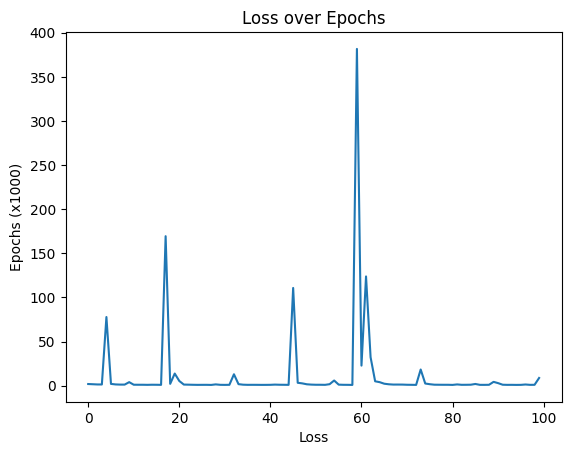

In [11]:
plt.figure()
plt.plot(all_losses)
plt.title('Loss over Epochs')
plt.xlabel('Loss')
plt.ylabel('Epochs (x1000)')
plt.show()

In [12]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)

In [15]:
# User inputted Prediction Test
sentence = ("Albert")
predict(sentence)


> Albert
French


In [14]:
train_acc = eval(X_train_tensors, y_train_tensors)
test_acc = eval(X_test_tensors, y_test_tensors)
print(f"Test Accuracy: {test_acc:.2f}% | Train Accuracy: {train_acc:.2f}%")

Test Accuracy: 58.33% | Train Accuracy: 59.78%
